# 06 Relationships between customer behaviors

In [1]:
import json
import sqlalchemy
import pandas as pd

from pprint import pprint

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())

chap4 = conf["chap4"]
chap6 = conf["chap6"]

## Dependent Data

- Listing 4.5
- 4.6.1 Dataset creation SQL program

In [4]:
obs = pd.read_sql_query("SELECT * FROM observation ORDER BY account_id, observation_date", conn) 
display(obs.shape)
obs.head()

(31333, 3)

,account_id,observation_date,is_churn
0,1,2020-02-23,False
1,1,2020-03-23,False
2,1,2020-04-23,False
3,2,2020-03-08,True
4,4,2020-02-24,False


In [5]:
metric = pd.read_sql_query("SELECT * FROM metric ORDER BY RANDOM() LIMIT 10000", conn) 
metric.head()

,account_id,metric_time,metric_name_id,metric_value
0,6635,2020-05-03,4,44.0
1,9157,2020-04-26,4,8.0
2,2263,2020-03-15,1,10.0
3,2097,2020-02-23,3,14.0
4,8328,2020-02-23,8,51.0


In [6]:
tmp = pd.read_sql_query("SELECT metric_name_id, COUNT(*) FROM metric GROUP BY metric_name_id", conn) 
tmp

,metric_name_id,count
0,0,163450
1,1,144501
2,2,160936
3,3,160510
4,4,154133
5,5,39979
6,6,155804
7,7,124663
8,8,158237


In [7]:
metric_name = pd.read_sql_query("SELECT * FROM metric_name", conn) 
metric_name.head()

,metric_name_id,metric_name
0,0,like_per_month
1,1,newfriend_per_month
2,2,post_per_month
3,3,adview_per_month
4,4,dislike_per_month


### Listing 4.5

- 4.6.1 Dataset creation SQL program

In [8]:
metric_interval = chap4["list6"]["params"]["%metric_interval"]
from_yyyy_mm_dd = chap4["defaults"]["%from_yyyy-mm-dd"]
to_yyyy_mm_dd = chap4["defaults"]["%to_yyyy-mm-dd"]

metric_interval, from_yyyy_mm_dd, to_yyyy_mm_dd

('7 day', '2020-02-09', '2020-05-10')

In [9]:
query = f"""\

WITH observation_params AS (
    SELECT  
        interval '{metric_interval}' AS metric_period,
        '{from_yyyy_mm_dd}'::timestamp AS obs_start,
        '{to_yyyy_mm_dd}'::timestamp AS obs_end
)

    SELECT 
        metric.account_id, 
        obs.observation_date, 
        obs.is_churn,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=5 THEN metric_value ELSE 0 END) AS unfriend_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=8 THEN metric_value ELSE 0 END) AS account_tenure
      FROM metric
INNER JOIN observation_params AS params
        ON metric_time BETWEEN params.obs_start AND params.obs_end    
INNER JOIN observation AS obs
        ON metric.account_id = obs.account_id
       AND metric.metric_time > (obs.observation_date - params.metric_period)::timestamp    
       AND metric.metric_time <= obs.observation_date::timestamp
  GROUP BY metric.account_id, metric.metric_time, obs.observation_date, obs.is_churn    
  ORDER BY obs.observation_date, metric.account_id

"""
res = pd.read_sql_query(query, conn).sort_values(["account_id", "observation_date"])
res.head(6)

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
4112,1,2020-02-23,False,2.0,0.0,6.0,1.0,3.0,1.0,6.0,6.0,26.0
14104,1,2020-03-23,False,2.0,1.0,6.0,2.0,2.0,2.0,7.0,4.0,54.0
24621,1,2020-04-23,False,1.0,1.0,2.0,4.0,4.0,1.0,7.0,3.0,82.0
9178,2,2020-03-08,True,67.0,7.0,49.0,124.0,120.0,0.0,0.0,0.0,55.0
4398,4,2020-02-24,False,36.0,4.0,27.0,36.0,5.0,1.0,32.0,8.0,25.0
14425,4,2020-03-24,False,37.0,8.0,39.0,40.0,9.0,0.0,39.0,3.0,53.0


In [14]:
res.is_churn.value_counts(normalize=True)

False    0.955159
True     0.044841
Name: is_churn, dtype: float64

In [37]:
res.drop(columns=["account_id"]).describe()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
count,31333.000000,31333.000000,31333.000000,31333.000000,31333.000000,31333.000000,31333.000000,31333.000000,31333.000000
mean,102.809849,7.194460,43.499697,41.348482,15.339450,0.293588,30.144321,7.964606,61.068777
std,206.346920,8.667298,79.422463,71.079170,21.976779,0.539168,67.060479,22.057363,29.593665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,18.000000,2.000000,9.000000,8.000000,4.000000,0.000000,5.000000,1.000000,26.000000
50%,44.000000,5.000000,21.000000,20.000000,9.000000,0.000000,12.000000,2.000000,54.000000
75%,106.000000,9.000000,48.000000,45.000000,18.000000,1.000000,28.000000,6.000000,83.000000
max,5653.000000,162.000000,2384.000000,1457.000000,405.000000,5.000000,1511.000000,579.000000,116.000000


- each row is an observation (snapshot) of an account before a subscription ends
- 95% of the observations are of not-churn, i.e. data are imbalanced
- metric data points are not evenly distributed, best to normalize before continue the investigation

### Listing 5.2 and Listing 5.3

Data skew and normalization

In [53]:
import pandas as pd
import numpy as np

In [49]:
tmp = res.drop(columns=["account_id", "is_churn"])

summary = tmp.describe().transpose()
summary['skew'] = tmp.skew()
summary['1%'] = tmp.quantile(q=0.01)
summary['99%'] = tmp.quantile(q=0.99)
summary['nonzero'] = tmp.astype(bool).sum(axis=0) / tmp.shape[0]

summary = summary[['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max']]
summary.columns = summary.columns.str.replace("%", "pct")

summary

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,102.809849,206.346920,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,43.499697,79.422463,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,41.348482,71.079170,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,15.339450,21.976779,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0
unfriend_per_month,31333.0,0.255801,0.293588,0.539168,1.832746,0.0,0.0,0.0,0.0,1.0,2.00,5.0
message_per_month,31333.0,0.962946,30.144321,67.060479,8.111159,0.0,0.0,5.0,12.0,28.0,304.68,1511.0
reply_per_month,31333.0,0.789264,7.964606,22.057363,9.263953,0.0,0.0,1.0,2.0,6.0,98.00,579.0
account_tenure,31333.0,1.000000,61.068777,29.593665,0.241582,18.0,19.0,26.0,54.0,83.0,116.00,116.0


About the summary stats

- If skew is zero, the low and high values are symmetrically distributed
  - If skew is positive, there're more observations higher than the mean
  - If skew is negative, there're more observations smaller than the mean
- Only "account_tenure" is close to symmetrically distributed
- Quatile are the metric values required to find a fixed percentile of the observations below that value
- With "like_per_month" quantiles
  - 50% (from 25% to  75%) of the accounts have between 18 and 106 likes per month
  - 25% with 18 likes, meaning 25% of the observations are less than 18 and 75% are greater than 18
  - 75% with 106 likes, meaning 75% of the observations have less than 106 and 25% have higher than 106

In [51]:
skew_thresh = 4.0
skewed_columns=summary[(summary['skew'] > skew_thresh) & (summary['min'] >= 0)]
skewed_columns

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,102.809849,206.346920,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
post_per_month,31333.0,0.985255,43.499697,79.422463,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,41.348482,71.079170,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,15.339450,21.976779,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0
message_per_month,31333.0,0.962946,30.144321,67.060479,8.111159,0.0,0.0,5.0,12.0,28.0,304.68,1511.0
reply_per_month,31333.0,0.789264,7.964606,22.057363,9.263953,0.0,0.0,1.0,2.0,6.0,98.00,579.0


In [52]:
skewed_columns.keys()

Index(['count', 'nonzero', 'mean', 'std', 'skew', 'min', '1pct', '25pct',
       '50pct', '75pct', '99pct', 'max'],
      dtype='object')

In [59]:
skewed_columns.index

Index(['like_per_month', 'post_per_month', 'adview_per_month',
       'dislike_per_month', 'message_per_month', 'reply_per_month'],
      dtype='object')

In [66]:
scored = res.copy().drop(columns=["account_id", "is_churn", "observation_date"])
for col in skewed_columns.index:
    scored[col] = np.log(1.0 + scored[col])
    summary.loc[col, 'mean'] = scored[col].mean()
    summary.loc[col, 'std'] = scored[col].std()
summary.head()

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,3.797733,1.309756,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,3.089984,1.196448,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,3.021980,1.218843,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,2.241344,1.063766,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0


In [67]:
scored.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
4112,1.098612,0.0,1.945910,0.693147,1.386294,1.0,1.945910,1.945910,26.0
14104,1.098612,1.0,1.945910,1.098612,1.098612,2.0,2.079442,1.609438,54.0
24621,0.693147,1.0,1.098612,1.609438,1.609438,1.0,2.079442,1.386294,82.0
9178,4.219508,7.0,3.912023,4.828314,4.795791,0.0,0.000000,0.000000,55.0
4398,3.610918,4.0,3.332205,3.610918,1.791759,1.0,3.496508,2.197225,25.0


In [68]:
scored = (scored - summary['mean']) / summary['std']
scored.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
4112,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010
14104,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861
24621,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287
9178,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070
4398,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801


In [70]:
scored["account_id"] = res["account_id"]
scored["is_churn"] = res["is_churn"]
scored["observation_date"] = res["observation_date"]
scored.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure,account_id,is_churn,observation_date
4112,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010,1,False,2020-02-23
14104,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861,1,False,2020-03-23
24621,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287,1,False,2020-04-23
9178,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070,2,True,2020-03-08
4398,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801,4,False,2020-02-24


In [76]:
df = scored.copy()
df.shape
# TODO: need to normalize the metrics

(31333, 12)

## Correlations

In [11]:
pprint(conf["chap6"])

{'defaults': {'data_set_path': 'socialnet7/socialnet7_dataset.csv',
              'type': 'py'},
 'list1': {'name': 'metric_pair_plot',
           'params': {'metric1': 'post_per_month', 'metric2': 'like_per_month'},
           'v1': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv'},
           'v10': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
                   'metric2': 'dislike_per_month'},
           'v11': {'metric2': 'unfriend_per_month'},
           'v12': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
                   'metric2': 'unfriend_per_month'},
           'v13': {'metric2': 'reply_per_month'},
           'v14': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
                   'metric2': 'reply_per_month'},
           'v15': {'metric2': 'account_tenure'},
           'v16': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
                   'metric2': 'account_tenure'},
           'v17': {'data_se

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

### 6.1 Coorelation between behaviours

- List 6.1

In [17]:
pprint(chap6["list1"])

{'name': 'metric_pair_plot',
 'params': {'metric1': 'post_per_month', 'metric2': 'like_per_month'},
 'v1': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv'},
 'v10': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'dislike_per_month'},
 'v11': {'metric2': 'unfriend_per_month'},
 'v12': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'unfriend_per_month'},
 'v13': {'metric2': 'reply_per_month'},
 'v14': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'reply_per_month'},
 'v15': {'metric2': 'account_tenure'},
 'v16': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'account_tenure'},
 'v17': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric1': 'like_per_month',
         'metric2': 'dislike_per_month'},
 'v2': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv'},
 'v3': {'metric2': 'message_per_month'},
 'v

In [33]:
metric_1 = chap6["list1"]["params"]["metric1"]
metric_2s = [chap6["list1"]["params"]["metric2"], *[chap6["list1"][f"v{i}"]["metric2"] for i in range(3, 17, 2)]]

metric_1, metric_2s

('post_per_month',
 ['like_per_month',
  'message_per_month',
  'newfriend_per_month',
  'adview_per_month',
  'dislike_per_month',
  'unfriend_per_month',
  'reply_per_month',
  'account_tenure'])

In [72]:
def metric_pair_plot(churn_data, metric1, metric2):

    met1_series = churn_data[metric1]
    met2_series = churn_data[metric2]

    corr = met1_series.corr(met2_series)

    plt.scatter(met1_series, met2_series, marker='.')

    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title('Correlation = %.2f' % corr)
    plt.tight_layout()
    plt.grid()

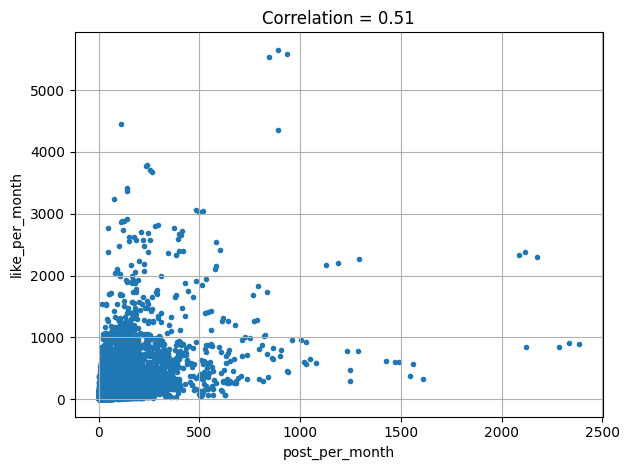

In [74]:
metric_pair_plot(res, metric_1, metric_2s[0])
# before standarization

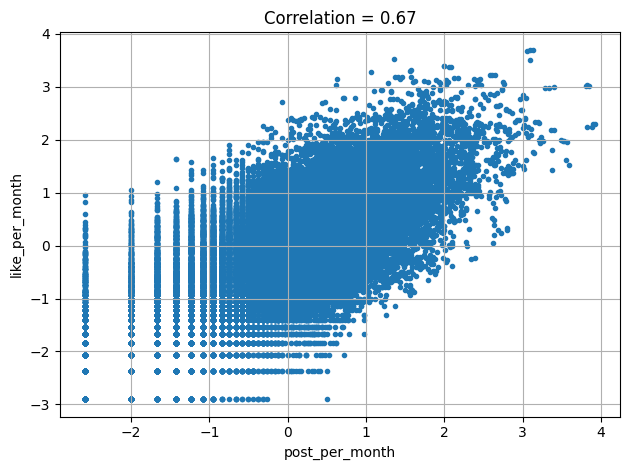

In [73]:
metric_pair_plot(df, metric_1, metric_2s[0])

In [77]:
df.reindex(sorted(df.columns), axis=1).corr()

,account_id,account_tenure,adview_per_month,dislike_per_month,is_churn,like_per_month,message_per_month,newfriend_per_month,post_per_month,reply_per_month,unfriend_per_month
account_id,1.000000,-0.218533,-0.024784,-0.026725,0.020784,-0.025796,-0.043801,-0.030537,-0.019498,-0.037570,-0.006412
account_tenure,-0.218533,1.000000,0.067222,0.072426,0.022649,0.082697,0.081487,0.068349,0.079250,0.066689,0.034203
adview_per_month,-0.024784,0.067222,1.000000,0.450351,-0.064589,0.666072,0.119217,0.521407,0.660935,0.058945,0.004877
dislike_per_month,-0.026725,0.072426,0.450351,1.000000,-0.048029,0.448820,0.151646,0.365215,0.449639,0.092583,0.010672
is_churn,0.020784,0.022649,-0.064589,-0.048029,1.000000,-0.123635,-0.120481,-0.083879,-0.127470,-0.098421,0.051344
like_per_month,-0.025796,0.082697,0.666072,0.448820,-0.123635,1.000000,0.088460,0.527764,0.666357,0.028133,0.004861
message_per_month,-0.043801,0.081487,0.119217,0.151646,-0.120481,0.088460,1.000000,0.072181,0.083063,0.812217,0.022621
newfriend_per_month,-0.030537,0.068349,0.521407,0.365215,-0.083879,0.527764,0.072181,1.000000,0.533085,0.009527,0.013073
post_per_month,-0.019498,0.079250,0.660935,0.449639,-0.127470,0.666357,0.083063,0.533085,1.000000,0.021143,0.008615
reply_per_month,-0.037570,0.066689,0.058945,0.092583,-0.098421,0.028133,0.812217,0.009527,0.021143,1.000000,0.020384
